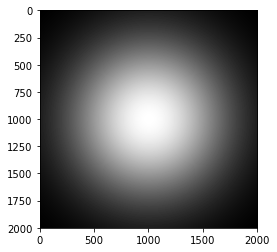

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

psf = np.load('2dGaussian.npy')
plt.imshow(psf, cmap='gray')
plt.show()


# grad = signal.convolve2d(ascent, scharr, boundary='symm', mode='same')

# import matplotlib.pyplot as plt

# fig, (ax_orig, ax_mag, ax_ang) = plt.subplots(3, 1, figsize=(6, 15))

# ax_orig.imshow(ascent, cmap='gray')

# ax_orig.set_title('Original')

# ax_orig.set_axis_off()

# ax_mag.imshow(np.absolute(grad), cmap='gray')

# ax_mag.set_title('Gradient magnitude')

# ax_mag.set_axis_off()

# ax_ang.imshow(np.angle(grad), cmap='hsv') # hsv is cyclic, like angles

# ax_ang.set_title('Gradient orientation')

# ax_ang.set_axis_off()